In [13]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import errno
import skimage.transform
from scipy.fftpack import fftn, ifftn
from skimage.feature import peak_local_max, canny
from skimage.transform import hough_circle 
import pydicom

In [14]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [15]:
def extract_roi_fft(data4D, pixel_spacing, minradius_mm=15, maxradius_mm=45, kernel_width=5, 
                center_margin=8, num_peaks=10, num_circles=20, radstep=2):
    """
    Returns center and radii of ROI region in (i,j) format
    """
    # Data shape: 
    # radius of the smallest and largest circles in mm estimated from the train set
    # convert to pixel counts

    pixel_spacing_X, pixel_spacing_Y, _,_ = pixel_spacing
    minradius = int(minradius_mm / pixel_spacing_X)
    maxradius = int(maxradius_mm / pixel_spacing_Y)

    ximagesize = data4D.shape[0]
    yimagesize = data4D.shape[1]
    zslices = data4D.shape[2]
    tframes = data4D.shape[3]
    xsurface = np.tile(range(ximagesize), (yimagesize, 1)).T
    ysurface = np.tile(range(yimagesize), (ximagesize, 1))
    lsurface = np.zeros((ximagesize, yimagesize))

    allcenters = []
    allaccums = []
    allradii = []

    for slice in range(zslices):
        ff1 = fftn([data4D[:,:,slice, t] for t in range(tframes)])
        fh = np.absolute(ifftn(ff1[1, :, :]))
        fh[fh < 0.1 * np.max(fh)] = 0.0
        image = 1. * fh / np.max(fh)
        # find hough circles and detect two radii
        edges = canny(image, sigma=3)
        hough_radii = np.arange(minradius, maxradius, radstep)
        # print hough_radii
        hough_res = hough_circle(edges, hough_radii)
        if hough_res.any():
            centers = []
            accums = []
            radii = []

            for radius, h in zip(hough_radii, hough_res):
                # For each radius, extract num_peaks circles
                peaks = peak_local_max(h, num_peaks=num_peaks)
                centers.extend(peaks)
                accums.extend(h[peaks[:, 0], peaks[:, 1]])
                radii.extend([radius] * num_peaks)
  
            # Keep the most prominent num_circles circles
            sorted_circles_idxs = np.argsort(accums)[::-1][:num_circles]

            for idx in sorted_circles_idxs:
                center_x, center_y = centers[idx]
                allcenters.append(centers[idx])
                allradii.append(radii[idx])
                allaccums.append(accums[idx])
                brightness = accums[idx]
                lsurface = lsurface + brightness * np.exp(
                    -((xsurface - center_x) ** 2 + (ysurface - center_y) ** 2) / kernel_width ** 2)

    lsurface = lsurface / lsurface.max()
    # select most likely ROI center
    roi_center = np.unravel_index(lsurface.argmax(), lsurface.shape)

    # determine ROI radius
    roi_x_radius = 0
    roi_y_radius = 0
    for idx in range(len(allcenters)):
        xshift = np.abs(allcenters[idx][0] - roi_center[0])
        yshift = np.abs(allcenters[idx][1] - roi_center[1])
        if (xshift <= center_margin) & (yshift <= center_margin):
            roi_x_radius = np.max((roi_x_radius, allradii[idx] + xshift))
            roi_y_radius = np.max((roi_y_radius, allradii[idx] + yshift))

    if roi_x_radius > 0 and roi_y_radius > 0:
        roi_radii = roi_x_radius, roi_y_radius
    else:
        roi_radii = None

    return roi_center, roi_radii

def roi_crop(image, label, roi, roi_radii, max_size=(180, 180), patch_size=(180, 180)):

    max_radius = roi_radii[1]
    max_size = (176, 176)
    patch_size = (176, 176)
    
    image, label = np.array(image), np.array(label)

    if CheckImageFitsInPatch(image, roi, max_radius, patch_size):
        # Center around roi
        patch_image = crop_img_patch_from_roi(image, roi, patch_size)
        patch_label = crop_img_patch_from_roi(label, roi, patch_size)
        # If patch size does not fit then pad or crop
        patch_image = resize_image_with_crop_or_pad_3D(patch_image[:,:, None], patch_size[0], patch_size[1])
        patch_label = resize_image_with_crop_or_pad_3D(patch_label[:,:, None], patch_size[0], patch_size[1])
    else:
        patch_image  = crop_img_patch_from_roi(image, roi, max_size)
        patch_label = crop_img_patch_from_roi(label, roi, max_size)
        patch_image = resize_sitk_2D(patch_image, patch_size)
        patch_label = resize_sitk_2D(patch_label, patch_size, interpolator=sitk.sitkNearestNeighbor)
        
    return patch_image, patch_label
import numpy as np


def CheckImageFitsInPatch(image, roi, max_radius, patch_size):
    boFlag = True
    max_radius += max_radius*.05
    if (max_radius > patch_size[0]/2) or (max_radius > patch_size[1]/2)\
        or (image.shape[0]>=512) or (image.shape[1]>=512):
        # print('The patch wont fit the roi: resize image', image.shape, max_radius, patch_size[0]/2)
        boFlag = False
    return boFlag

def crop_img_patch_from_roi(image_2D, roi_center, patch_size=(128,128)):
    """
    This code extracts a patch of defined size from the given center point of the image
    and returns parameters for padding and translation to original location of the image
    Args:
    2D: Volume:  Y, X
    """

    cols, rows = image_2D.shape
    patch_cols = np.uint16(max(0, roi_center[0] - patch_size[0]/2))
    patch_rows = np.uint16(max(0, roi_center[1] - patch_size[0]/2))
    # print (patch_cols,patch_cols+patch_size[0], patch_rows,patch_rows+patch_size[0])
    patch_img = image_2D[patch_cols:patch_cols+patch_size[0], patch_rows:patch_rows+patch_size[0]]
    return patch_img

def extract_patch(image_2D, roi_center, patch_size=(128, 128)):
    """
    This code extracts a patch of defined size from the given center point of the image
    and returns parameters for padding and translation to original location of the image
    Args:
    2D: Volume: X ,Y
    """
    cols, rows = image_2D.shape

    patch_cols = np.uint16(max(0, roi_center[0] - patch_size[0]/2))
    patch_rows = np.uint16(max(0, roi_center[1] - patch_size[0]/2))
    patch_img = image_2D[patch_cols:patch_cols+patch_size[0], patch_rows:patch_rows+patch_size[0]]
    if patch_img.shape != patch_size:
        # Pad the image with appropriately to patch_size
        print ('Not supported yet: Patch_size is bigger than the input image')
    # patch_img = np.expand_dims(patch_img, axis=1)
    pad_params = {'rows': rows, 'cols': cols, 'tx': patch_rows, 'ty': patch_cols}
    return patch_img, pad_params

def resize_image_with_crop_or_pad_3D(image, target_height, target_width):
    """Crops and/or pads an image to a target width and height.
    Resizes an image to a target width and height by either centrally
    cropping the image or padding it evenly with zeros.
    If `width` or `height` is greater than the specified `target_width` or
    `target_height` respectively, this op centrally crops along that dimension.
    If `width` or `height` is smaller than the specified `target_width` or
    `target_height` respectively, this op centrally pads with 0 along that
    dimension.
    Args:
    image: 3-D Tensor of shape `[ height, width, channels]` or
    target_height: Target height.
    target_width: Target width.
    Raises:
    ValueError: if `target_height` or `target_width` are zero or negative.
    Returns:
    Cropped and/or padded image.
    """

    # `crop_to_bounding_box` and `pad_to_bounding_box` have their own checks.
    def max_(x, y):
        return max(x, y)

    def min_(x, y):
        return min(x, y)

    def equal_(x, y):
        return x == y

    height, width, _ = image.shape
    width_diff = target_width - width
    offset_crop_width = max_(-width_diff // 2, 0)
    offset_pad_width = max_(width_diff // 2, 0)

    height_diff = target_height - height
    offset_crop_height = max_(-height_diff // 2, 0)
    offset_pad_height = max_(height_diff // 2, 0)

    # Maybe crop if needed.
    cropped = crop_to_bounding_box_3D(image, offset_crop_height, offset_crop_width,
                                 min_(target_height, height),
                                 min_(target_width, width))

    # Maybe pad if needed.
    resized = pad_to_bounding_box_3D(cropped, offset_pad_height, offset_pad_width,
                                target_height, target_width)
    return resized

def pad_to_bounding_box_3D(image, offset_height, offset_width, target_height,
                        target_width):
    """Pad `image` with zeros to the specified `height` and `width`.
    Adds `offset_height` rows of zeros on top, `offset_width` columns of
    zeros on the left, and then pads the image on the bottom and right
    with zeros until it has dimensions `target_height`, `target_width`.
    This op does nothing if `offset_*` is zero and the image already has size
    `target_height` by `target_width`.
    Args:
    image: 2-D Tensor of shape `[height, width]`
    offset_height: Number of rows of zeros to add on top.
    offset_width: Number of columns of zeros to add on the left.
    target_height: Height of output image.
    target_width: Width of output image.
    Returns:
    If `image` was a 3-D float Tensor of shape
    `[target_height, target_width, channels]`
    Raises:
    ValueError: If the shape of `image` is incompatible with the `offset_*` or
      `target_*` arguments, or either `offset_height` or `offset_width` is
      negative.
    """
    height, width, _ = image.shape

    after_padding_width = target_width - offset_width - width
    after_padding_height = target_height - offset_height - height

    assert (offset_height >= 0),"offset_height must be >= 0"    
    assert (offset_width >= 0),"width must be <= target - offset"    
    assert (after_padding_width >= 0),"height must be <= target - offset"    
    assert (after_padding_height >= 0),"height must be <= target - offset"    

    # Do not pad on the depth dimensions.
    padded = np.lib.pad(image, ((offset_height, after_padding_height),
                     (offset_width, after_padding_width), (0, 0)), 'constant')
    return padded


def crop_to_bounding_box_3D(image, offset_height, offset_width, target_height,
                         target_width):
    """Crops an image to a specified bounding box.
    This op cuts a rectangular part out of `image`. The top-left corner of the
    returned image is at `offset_height, offset_width` in `image`, and its
    lower-right corner is at
    `offset_height + target_height, offset_width + target_width`.
    Args:
    image: 3-D Tensor of shape `[height, width, channels]`.
    offset_height: Vertical coordinate of the top-left corner of the result in
                   the input.
    offset_width: Horizontal coordinate of the top-left corner of the result in
                  the input.
    target_height: Height of the result.
    target_width: Width of the result.
    Returns:
    If `image` was  a 3-D float Tensor of shape
    `[target_height, target_width, channels]`
    Raises:
    ValueError: If the shape of `image` is incompatible with the `offset_*` or
      `target_*` arguments, or either `offset_height` or `offset_width` is
      negative, or either `target_height` or `target_width` is not positive.
    """
    height, width, _ = image.shape

    assert (offset_width >= 0),"offset_width must be >= 0."    
    assert (offset_height >= 0),"offset_height must be >= 0."    
    assert (target_width > 0),"target_width must be > 0."    
    assert (target_height > 0),"target_height must be > 0." 
    assert (width >= (target_width + offset_width)),"width must be >= target + offset."    
    assert (height >= (target_height + offset_height)),"height must be >= target + offset."    
    cropped = image[offset_height: target_height+offset_height, offset_width: target_width+offset_width, :]
    return cropped


def pad_to_bounding_box(image, offset_height, offset_width, target_height,
                        target_width, pad_mode='symmetric'):
    """Pad `image` with zeros to the specified `height` and `width`.
    Adds `offset_height` rows of zeros on top, `offset_width` columns of
    zeros on the left, and then pads the image on the bottom and right
    with zeros until it has dimensions `target_height`, `target_width`.
    This op does nothing if `offset_*` is zero and the image already has size
    `target_height` by `target_width`.
    Args:
    image: 2-D Tensor of shape `[height, width]`
    offset_height: Number of rows of zeros to add on top.
    offset_width: Number of columns of zeros to add on the left.
    target_height: Height of output image.
    target_width: Width of output image.
    Returns:
    If `image` was 2-D, a 2-D float Tensor of shape
    `[target_height, target_width]`
    Raises:
    ValueError: If the shape of `image` is incompatible with the `offset_*` or
      `target_*` arguments, or either `offset_height` or `offset_width` is
      negative.
    """
    height, width = image.shape

    after_padding_width = target_width - offset_width - width
    after_padding_height = target_height - offset_height - height

    assert (offset_height >= 0),"offset_height must be >= 0"    
    assert (offset_width >= 0),"width must be <= target - offset"    
    assert (after_padding_width >= 0),"height must be <= target - offset"    
    assert (after_padding_height >= 0),"height must be <= target - offset"    

    # Do not pad on the depth dimensions.
    padded = np.lib.pad(image, ((offset_height, after_padding_height),
                     (offset_width, after_padding_width)), pad_mode)
    return padded


def crop_to_bounding_box(image, offset_height, offset_width, target_height,
                         target_width):
    """Crops an image to a specified bounding box.
    This op cuts a rectangular part out of `image`. The top-left corner of the
    returned image is at `offset_height, offset_width` in `image`, and its
    lower-right corner is at
    `offset_height + target_height, offset_width + target_width`.
    Args:
    image: 2-D Tensor of shape `[height, width]`.
    offset_height: Vertical coordinate of the top-left corner of the result in
                   the input.
    offset_width: Horizontal coordinate of the top-left corner of the result in
                  the input.
    target_height: Height of the result.
    target_width: Width of the result.
    Returns:
    If `image` was 2-D, a 2-D float Tensor of shape
    `[target_height, target_width]`
    Raises:
    ValueError: If the shape of `image` is incompatible with the `offset_*` or
      `target_*` arguments, or either `offset_height` or `offset_width` is
      negative, or either `target_height` or `target_width` is not positive.
    """
    height, width = image.shape

    assert (offset_width >= 0),"offset_width must be >= 0."    
    assert (offset_height >= 0),"offset_height must be >= 0."    
    assert (target_width > 0),"target_width must be > 0."    
    assert (target_height > 0),"target_height must be > 0." 
    assert (width >= (target_width + offset_width)),"width must be >= target + offset."    
    assert (height >= (target_height + offset_height)),"height must be >= target + offset."    
    cropped = image[offset_height: target_height+offset_height, offset_width: target_width+offset_width]
    return cropped

def resize_image_with_crop_or_pad(image, target_height, target_width, pad_mode='symmetric'):
    """Crops and/or pads an image to a target width and height.
    Resizes an image to a target width and height by either centrally
    cropping the image or padding it evenly with zeros.
    If `width` or `height` is greater than the specified `target_width` or
    `target_height` respectively, this op centrally crops along that dimension.
    If `width` or `height` is smaller than the specified `target_width` or
    `target_height` respectively, this op centrally pads with 0 along that
    dimension.
    Args:
    image: 2-D Tensor of shape `[ height, width]` or
    target_height: Target height.
    target_width: Target width.
    Raises:
    ValueError: if `target_height` or `target_width` are zero or negative.
    Returns:
    Cropped and/or padded image.
    """

    # `crop_to_bounding_box` and `pad_to_bounding_box` have their own checks.
    def max_(x, y):
        return max(x, y)

    def min_(x, y):
        return min(x, y)

    def equal_(x, y):
        return x == y

    height, width = image.shape
    width_diff = target_width - width
    offset_crop_width = max_(-width_diff // 2, 0)
    offset_pad_width = max_(width_diff // 2, 0)

    height_diff = target_height - height
    offset_crop_height = max_(-height_diff // 2, 0)
    offset_pad_height = max_(height_diff // 2, 0)

    # Maybe crop if needed.
    cropped = crop_to_bounding_box(image, offset_crop_height, offset_crop_width,
                                 min_(target_height, height),
                                 min_(target_width, width))

    # Maybe pad if needed.
    resized = pad_to_bounding_box(cropped, offset_pad_height, offset_pad_width,
                                target_height, target_width, pad_mode)

    return resized

In [16]:
def preprocess():
    data_path = "/ceph/project-share/cardiac/data/ACDC/ACDC_DataSet/new_training/training"
    save_path = "/ceph/project-share/cardiac/code/workspace/huimin/Cardiac/data/ACDC/training"
    for name in os.listdir(data_path):
        # make result directoires
        p_folder = os.path.join(data_path, name)
        s_folder = os.path.join(save_path, name)
        mkdir_p(s_folder)
        
        # calculate roi centers and radius
        data = nib.load(os.path.join(p_folder, name+"_4d.nii.gz"))
        ed_pixel_spacings = data.header['pixdim'][1:5]
        data = data.get_fdata()
        roi_center, roi_radii = extract_roi_fft(data, ed_pixel_spacings)
        print("data: ", data.shape) # （H,W,num_slices,num_frames）
        
        config = open(os.path.join(p_folder, "Info.cfg"), "r").readlines()
        ed = config[0][4:-1]
        es = config[1][4:-1]
        nb_frame = config[4][-3:-1]
        
        # ED
        ed_nifti = os.path.join(p_folder, name+"_frame{:02d}.nii.gz".format(int(ed)))
        ed_nifti = nib.load(ed_nifti)
        ed_nifti_gt = os.path.join(p_folder, name+"_frame{:02d}_gt.nii.gz".format(int(ed)))
        ed_nifti_gt = nib.load(ed_nifti_gt)
        ed_imgs = ed_nifti.get_fdata()
        ed_pixel_spacings = ed_nifti.header['pixdim'][1:3]
        ed_gts = ed_nifti_gt.get_fdata()
        ed_gts = (ed_nifti_gt.get_fdata() == 3).astype('float32')
        
        for i in range(ed_imgs.shape[2]):
            img, mask = preprocess_img(ed_imgs[:, :, i], ed_gts[:, :, i], ed_pixel_spacings, roi_center, roi_radii)
            if np.sum(mask) < 10: continue
            np.save(os.path.join(s_folder, name+"_ED_image_{:02d}.npy".format(i)), img)
            np.save(os.path.join(s_folder, name+"_ED_mask_{:02d}.npy".format(i)), mask)
        
        # ES
        es_nifti = os.path.join(p_folder, name+"_frame{:02d}.nii.gz".format(int(es)))
        es_nifti = nib.load(es_nifti)
        es_nifti_gt = os.path.join(p_folder, name+"_frame{:02d}_gt.nii.gz".format(int(es)))
        es_nifti_gt = nib.load(es_nifti_gt)
        es_imgs = es_nifti.get_fdata()
        es_pixel_spacings = es_nifti.header['pixdim'][1:3]
        es_gts = (es_nifti_gt.get_fdata() == 3).astype('float32')
        
        for i in range(es_imgs.shape[2]):
            img, mask = preprocess_img(es_imgs[:, :, i], es_gts[:, :, i], es_pixel_spacings, roi_center, roi_radii)
            np.save(os.path.join(s_folder, name+"_ES_image_{:02d}.npy".format(i)), img)
            np.save(os.path.join(s_folder, name+"_ES_mask_{:02d}.npy".format(i)), mask)
            

In [17]:
def preprocess_img(img, mask, pixel_spacing, roi_center, roi_radii, output_dim = (176, 176)):
    img = cv2.resize(img, (0, 0), fx=pixel_spacing[0], fy=pixel_spacing[1])
    mask = cv2.resize(mask, (0, 0), fx=pixel_spacing[0], fy=pixel_spacing[1])
    roi_center = [roi_center[0]*pixel_spacing[0], roi_center[1]*pixel_spacing[1]]
    roi_radii = [roi_radii[0]*pixel_spacing[0], roi_radii[1]*pixel_spacing[1]]
    
    img, mask = roi_crop(img, mask, roi_center, roi_radii)
    
    clahe = cv2.createCLAHE(tileGridSize=(4, 4), clipLimit=3.)
    img = clahe.apply(np.array(img, dtype=np.uint16))[..., np.newaxis]
    img = scale(img)
    if img.ndim < 3: img = img[..., np.newaxis].astype(np.float16)
    if mask.ndim < 3: mask = mask[..., np.newaxis]
    return img, mask.astype(int)

def scale(img):
    maxPixel = float(max([max(row) for row in img]))
    return img/maxPixel

In [18]:
preprocess()

data:  (214, 256, 8, 25)
data:  (174, 208, 15, 15)
data:  (256, 216, 7, 35)
data:  (224, 154, 16, 17)
data:  (216, 256, 6, 21)
data:  (224, 256, 10, 30)
data:  (216, 256, 10, 30)
data:  (184, 256, 10, 30)
data:  (208, 256, 9, 28)
data:  (224, 256, 10, 30)
data:  (216, 256, 9, 30)
data:  (256, 256, 10, 30)
data:  (256, 208, 9, 22)
data:  (256, 216, 9, 25)
data:  (192, 256, 10, 30)
data:  (216, 256, 7, 30)
data:  (208, 256, 8, 35)
data:  (232, 256, 9, 35)
data:  (240, 256, 10, 30)
data:  (216, 304, 8, 34)
data:  (208, 256, 7, 35)
data:  (216, 256, 9, 30)
data:  (256, 184, 8, 28)
data:  (154, 224, 16, 19)
data:  (256, 216, 9, 21)
data:  (216, 256, 10, 35)
data:  (256, 216, 9, 30)
data:  (216, 256, 9, 30)
data:  (216, 256, 8, 30)
data:  (208, 256, 8, 20)
data:  (216, 256, 8, 20)
data:  (168, 224, 14, 14)
data:  (200, 256, 10, 28)
data:  (216, 256, 10, 30)
data:  (216, 256, 9, 19)
data:  (256, 216, 10, 30)
data:  (428, 512, 8, 25)
data:  (200, 256, 7, 28)
data:  (256, 216, 10, 30)
data:  (2

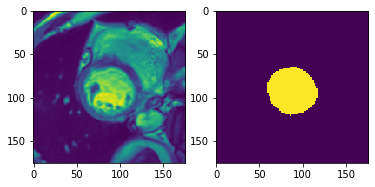

In [19]:
a = np.load("/ceph/project-share/cardiac/code/workspace/huimin/Cardiac/data/ACDC/training/patient077/patient077_ED_image_01.npy")
b = np.load("/ceph/project-share/cardiac/code/workspace/huimin/Cardiac/data/ACDC/training/patient077/patient077_ED_mask_01.npy")

_, axs = plt.subplots(1, 2)
axs[0].imshow(a[:, :, 0])
axs[1].imshow(b[:, :, 0])